# 1. Analysis of Nashville Marked in the past 12 Months


In [1]:
# Loading required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import string #for punctuation
from pycontractions  import Contractions

In [2]:
# Setting the maximum display option
# pd.set_option('display.max_rows', None)
# pd.options.display.max_colwidth = 500

## Reading Listings

In [3]:
# Merge 4 quarters listings data
# ignore_index was used to generate the sequential indexes when multiple files are joined, otherwise the file index will be used (i.e. when
# each file is appended, the index will start from 0 again)
df_listings = pd.concat([pd.read_csv('data/2021-12-17/listings1.csv'),
                pd.read_csv('data/2022-03-20/listings2.csv'),
                pd.read_csv('data/2022-06-13/listings3.csv'),
                pd.read_csv('data/2022-09-15/listings4.csv')], axis = 0 , ignore_index=True)
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,source
0,6422,https://www.airbnb.com/rooms/6422,20211217003604,2021-12-17,Nashville Charm,30 day or more rental during COVID. Show COVID...,Historic East Nashville is home to many new an...,https://a0.muscache.com/pictures/pro_photo_too...,12172,https://www.airbnb.com/users/show/12172,...,4.92,4.98,NaN,f,1,0,1,0,4.38,NaN
1,39870,https://www.airbnb.com/rooms/39870,20211217003604,2021-12-17,Close to Vanderbilt 2,This is a room and private bathroom in my cozy...,"The house is in a safe, quiet, ""college"" neig...",https://a0.muscache.com/pictures/43420407-69b6...,171184,https://www.airbnb.com/users/show/171184,...,4.94,4.94,NaN,f,1,0,1,0,4.17,NaN
2,72906,https://www.airbnb.com/rooms/72906,20211217003604,2021-12-17,Vandy/Belmont/10 mins to Broadway - Sunny 800 ...,Entire top floor. Private. 800 sq ft of bright...,Historic Belmont-Hillsboro neighborhood. Walk-...,https://a0.muscache.com/pictures/58602855/3788...,176117,https://www.airbnb.com/users/show/176117,...,4.96,4.88,NaN,f,1,1,0,0,4.74,NaN
3,258817,https://www.airbnb.com/rooms/258817,20211217003604,2021-12-17,ButterflyRoom-private bath- open in oct,Morningstar House! Extended stay - 3+ months- ...,"I'm very near the Percy Priest Lake, natural ...",https://a0.muscache.com/pictures/eef19bc4-2743...,22296,https://www.airbnb.com/users/show/22296,...,4.74,4.73,NaN,f,7,0,6,1,0.79,NaN
4,289242,https://www.airbnb.com/rooms/289242,20211217003604,2021-12-17,"MorningstarHouse, monthly room- open sept",Morningstar House! Extended stay - price reduc...,The Morningstar House is in a quiet cul-de-sac...,https://a0.muscache.com/pictures/40a7ab72-20f7...,22296,https://www.airbnb.com/users/show/22296,...,4.47,4.69,NaN,f,7,0,6,1,0.63,NaN


## Reading Calendars

In [4]:
# Merge 4 quarters calendar data
df_calendar_s1 = pd.read_csv('data/2021-12-17/calendar1.csv', parse_dates=['date'])
df_calendar_s1['scrape_date'] = '2021-12-17'
df_calendar_s2 = pd.read_csv('data/2022-03-20/calendar2.csv', parse_dates=['date'])
df_calendar_s2['scrape_date'] = '2022-03-20'
df_calendar_s3 = pd.read_csv('data/2022-06-13/calendar3.csv', parse_dates=['date'])
df_calendar_s3['scrape_date'] = '2022-06-13'
df_calendar_s4 = pd.read_csv('data/2022-09-15/calendar4.csv', parse_dates=['date'])
df_calendar_s4['scrape_date'] = '2022-09-15'

print(df_calendar_s1['date'].min(),
df_calendar_s2['date'].min(),
df_calendar_s3['date'].min(),
df_calendar_s4['date'].min())

2021-12-17 00:00:00 2022-03-20 00:00:00 2022-06-13 00:00:00 2022-09-15 00:00:00


### Cleaning

The issue is that there are a few listings in each of the scraped dataframe that are not available for the first day of scrape, but are available for subsequent dates. We are imputing those listings by copying entries from the +1 day.

In [5]:

missing_listing_ids = df_calendar_s2.mask(df_calendar_s2[df_calendar_s2['date'] == '2022-03-21']['listing_id'].isin(df_calendar_s2[df_calendar_s2['date'] == '2022-03-20']['listing_id']))\
    ['listing_id'].dropna()
df_tmp_impute_rows = df_calendar_s2[(df_calendar_s2['date'] == '2022-03-21') & (df_calendar_s2['listing_id'].isin(missing_listing_ids))].copy()
df_tmp_impute_rows['date'] = datetime.strptime('2022-03-20', '%Y-%m-%d')
df_calendar_s2 = pd.concat([df_calendar_s2, df_tmp_impute_rows], axis=0, ignore_index=True).reset_index(drop=True)

In [6]:
missing_listing_ids = df_calendar_s3.mask(df_calendar_s3[df_calendar_s3['date'] == '2022-06-14']['listing_id'].isin(df_calendar_s3[df_calendar_s3['date'] == '2022-06-13']['listing_id']))\
    ['listing_id'].dropna()
df_tmp_impute_rows = df_calendar_s3[(df_calendar_s3['date'] == '2022-06-14') & (df_calendar_s3['listing_id'].isin(missing_listing_ids))].copy()
df_tmp_impute_rows['date'] = datetime.strptime('2022-06-13', '%Y-%m-%d')
df_calendar_s3 = pd.concat([df_calendar_s3, df_tmp_impute_rows], axis=0, ignore_index=True).reset_index(drop=True)

In [7]:
missing_listing_ids = df_calendar_s4.mask(df_calendar_s4[df_calendar_s4['date'] == '2022-09-16']['listing_id'].isin(df_calendar_s4[df_calendar_s4['date'] == '2022-09-15']['listing_id']))\
    ['listing_id'].dropna()
df_tmp_impute_rows = df_calendar_s4[(df_calendar_s4['date'] == '2022-09-16') & (df_calendar_s4['listing_id'].isin(missing_listing_ids))].copy()
df_tmp_impute_rows['date'] = datetime.strptime('2022-09-15', '%Y-%m-%d')
df_calendar_s4 = pd.concat([df_calendar_s4, df_tmp_impute_rows], axis=0, ignore_index=True).reset_index(drop=True)

In [8]:
df_calendar = pd.concat([
    df_calendar_s1[df_calendar_s1['date'] < '2022-03-20'],
    df_calendar_s2[df_calendar_s2['date'] < '2022-06-13'],
    df_calendar_s3[df_calendar_s3['date'] < '2022-09-15'],
    df_calendar_s4[df_calendar_s4['date'] < '2023-09-15']
], axis=0, ignore_index=True)
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,scrape_date
0,6422,2021-12-17,f,$40.00,$40.00,30.0,365.0,2021-12-17
1,3095791,2021-12-17,t,$80.00,$80.00,30.0,1125.0,2021-12-17
2,3095791,2021-12-18,t,$80.00,$80.00,30.0,1125.0,2021-12-17
3,3095791,2021-12-19,t,$60.00,$60.00,30.0,1125.0,2021-12-17
4,3095791,2021-12-20,t,$60.00,$60.00,30.0,1125.0,2021-12-17


In [9]:
df_calendar.isnull().sum() #/ len(df_calendar)

listing_id         0
date               0
available          0
price             12
adjusted_price    12
minimum_nights     1
maximum_nights     1
scrape_date        0
dtype: int64

## Market Supply

Defined as number of listings available for Nashville in Airbnb on a particular day/month/

We will also include deltas

**Done in Tableau sheet Analysis.twb**

In [10]:
df_calendar.to_csv('calendar.csv', index=False)

**Delta Calculation**

In [11]:
# Create dictionary to hold delta values
deltas = []

In [12]:
# Delta of New listings added --> get the listings that were added in second scrape, but were not there in first scrape
cal1_unique_listings = pd.Series(df_calendar_s1['listing_id'].unique())
cal2_unique_listings = pd.Series(df_calendar_s2['listing_id'].unique())
deltas.append({
    'Date': '2022-03-20',
    'New_Listings': df_calendar_s2.mask(cal2_unique_listings.isin(cal1_unique_listings))['listing_id'].dropna().shape[0],
    'Removed_Listings': df_calendar_s1.mask(cal1_unique_listings.isin(cal2_unique_listings))['listing_id'].dropna().shape[0]
})


In [13]:
# Delta of New listings added --> get the listings that were added in third scrape, but were not there in second scrape
cal3_unique_listings = pd.Series(df_calendar_s3['listing_id'].unique())
deltas.append({
    'Date': '2022-06-13',
    'New_Listings': df_calendar_s3.mask(cal3_unique_listings.isin(cal2_unique_listings))['listing_id'].dropna().shape[0],
    'Removed_Listings': df_calendar_s2.mask(cal2_unique_listings.isin(cal3_unique_listings))['listing_id'].dropna().shape[0]
})

In [14]:
# Delta of New listings added --> get the listings that were added in fourth scrape, but were not there in third scrape
cal4_unique_listings = pd.Series(df_calendar_s4['listing_id'].unique())
deltas.append({
    'Date': '2022-09-15',
    'New_Listings': df_calendar_s4.mask(cal4_unique_listings.isin(cal3_unique_listings))['listing_id'].dropna().shape[0],
    'Removed_Listings': df_calendar_s3.mask(cal3_unique_listings.isin(cal4_unique_listings))['listing_id'].dropna().shape[0]
})

In [15]:
deltas

[{'Date': '2022-03-20', 'New_Listings': 1231, 'Removed_Listings': 792},
 {'Date': '2022-06-13', 'New_Listings': 1043, 'Removed_Listings': 599},
 {'Date': '2022-09-15', 'New_Listings': 1112, 'Removed_Listings': 622}]

Text(0, 0.5, 'Total Listings Added during scrape')

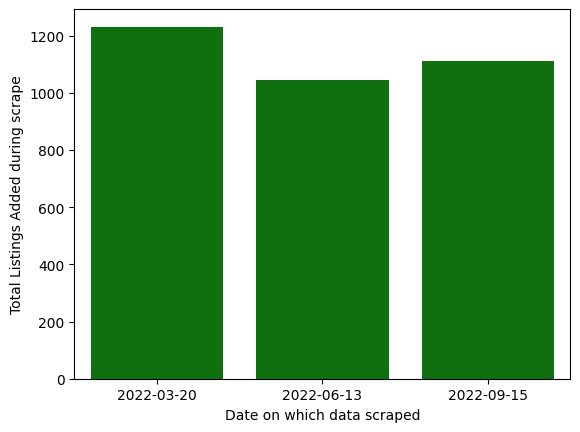

In [16]:
# pd.DataFrame(deltas).plot.bar('Date', 'New_Listings')
sns.barplot(data= pd.DataFrame(deltas) , x = 'Date' , y = 'New_Listings', color = 'green')
plt.xlabel("Date on which data scraped")
plt.ylabel("Total Listings Added during scrape")

Text(0, 0.5, 'Total Listings Removed from previous scrape')

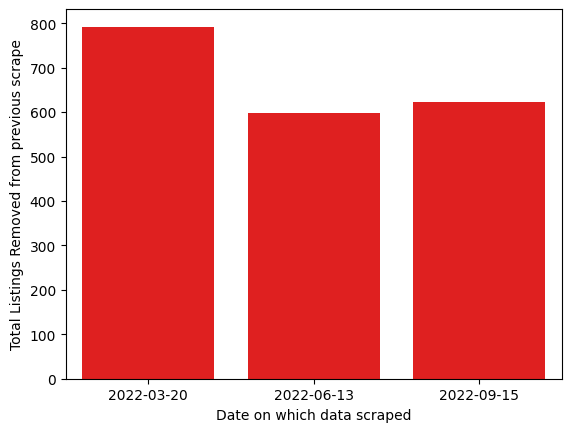

In [17]:
# pd.DataFrame(deltas).plot.bar('Date', 'Removed_Listings')
sns.barplot(data= pd.DataFrame(deltas) , x = 'Date' , y = 'Removed_Listings', color = 'red')
plt.xlabel("Date on which data scraped")
plt.ylabel("Total Listings Removed from previous scrape")

**Median Price on weekday & weekends**

In [18]:
df_calendar[df_calendar.isna().any(axis=1)]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,scrape_date
1855344,3710914,2022-09-15,f,$169.00,$135.00,NaN,NaN,2022-09-15
2633109,43069693,2023-09-03,f,NaN,NaN,2.0,365.0,2022-09-15
2633110,43069693,2023-09-04,f,NaN,NaN,2.0,365.0,2022-09-15
2633111,43069693,2023-09-05,f,NaN,NaN,2.0,365.0,2022-09-15
2633112,43069693,2023-09-06,f,NaN,NaN,2.0,365.0,2022-09-15
2633113,43069693,2023-09-07,f,NaN,NaN,2.0,365.0,2022-09-15
2633114,43069693,2023-09-08,f,NaN,NaN,2.0,365.0,2022-09-15
2633115,43069693,2023-09-09,f,NaN,NaN,2.0,365.0,2022-09-15
2633116,43069693,2023-09-10,f,NaN,NaN,2.0,365.0,2022-09-15
2633117,43069693,2023-09-11,f,NaN,NaN,2.0,365.0,2022-09-15


In [19]:
df_listings[df_listings['id']==3710914][['host_id','minimum_nights','maximum_nights','last_scraped']]

,host_id,minimum_nights,maximum_nights,last_scraped
107,225274317,2,180,2021-12-17
6484,225274317,2,180,2022-03-20
13207,10259524,2,180,2022-06-13
20503,10259524,1,180,2022-09-16


In [20]:
df_calendar[(df_calendar['listing_id']==43069693) & (df_calendar['date']=='2023-09-02') ]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,scrape_date
2633108,43069693,2023-09-02,f,$59.00,$59.00,2.0,365.0,2022-09-15


In [21]:
# Imputing the missing values of minimum_night & maximum_night of listing_id = 3710914 of date - 2022-09-15 with minimum_night & maximum_night of listing file 
df_calendar.iloc[1855344,5:7] = [2,180]
df_calendar.iloc[1855344,:]

listing_id                    3710914
date              2022-09-15 00:00:00
available                           f
price                         $169.00
adjusted_price                $135.00
minimum_nights                    2.0
maximum_nights                  180.0
scrape_date                2022-09-15
Name: 1855344, dtype: object

In [22]:
# Imputing missing values of listing_id = 43069693 with what the one previous date value has
df_calendar.iloc[2633109 : 2633121 ,3:5]  = ['$59.00', '$59.00']
df_calendar.iloc[2633109 : 2633121 ,3:5]

,price,adjusted_price
2633109,$59.00,$59.00
2633110,$59.00,$59.00
2633111,$59.00,$59.00
2633112,$59.00,$59.00
2633113,$59.00,$59.00
2633114,$59.00,$59.00
2633115,$59.00,$59.00
2633116,$59.00,$59.00
2633117,$59.00,$59.00
2633118,$59.00,$59.00


In [23]:
df_calendar['price_dollars'] = df_calendar['price'].replace('[\$,]', '', regex=True).astype(float)
df_calendar['price_dollars']

# Update the CSV
df_calendar.to_csv('calendar.csv', index=False)

<AxesSubplot: xlabel='date'>

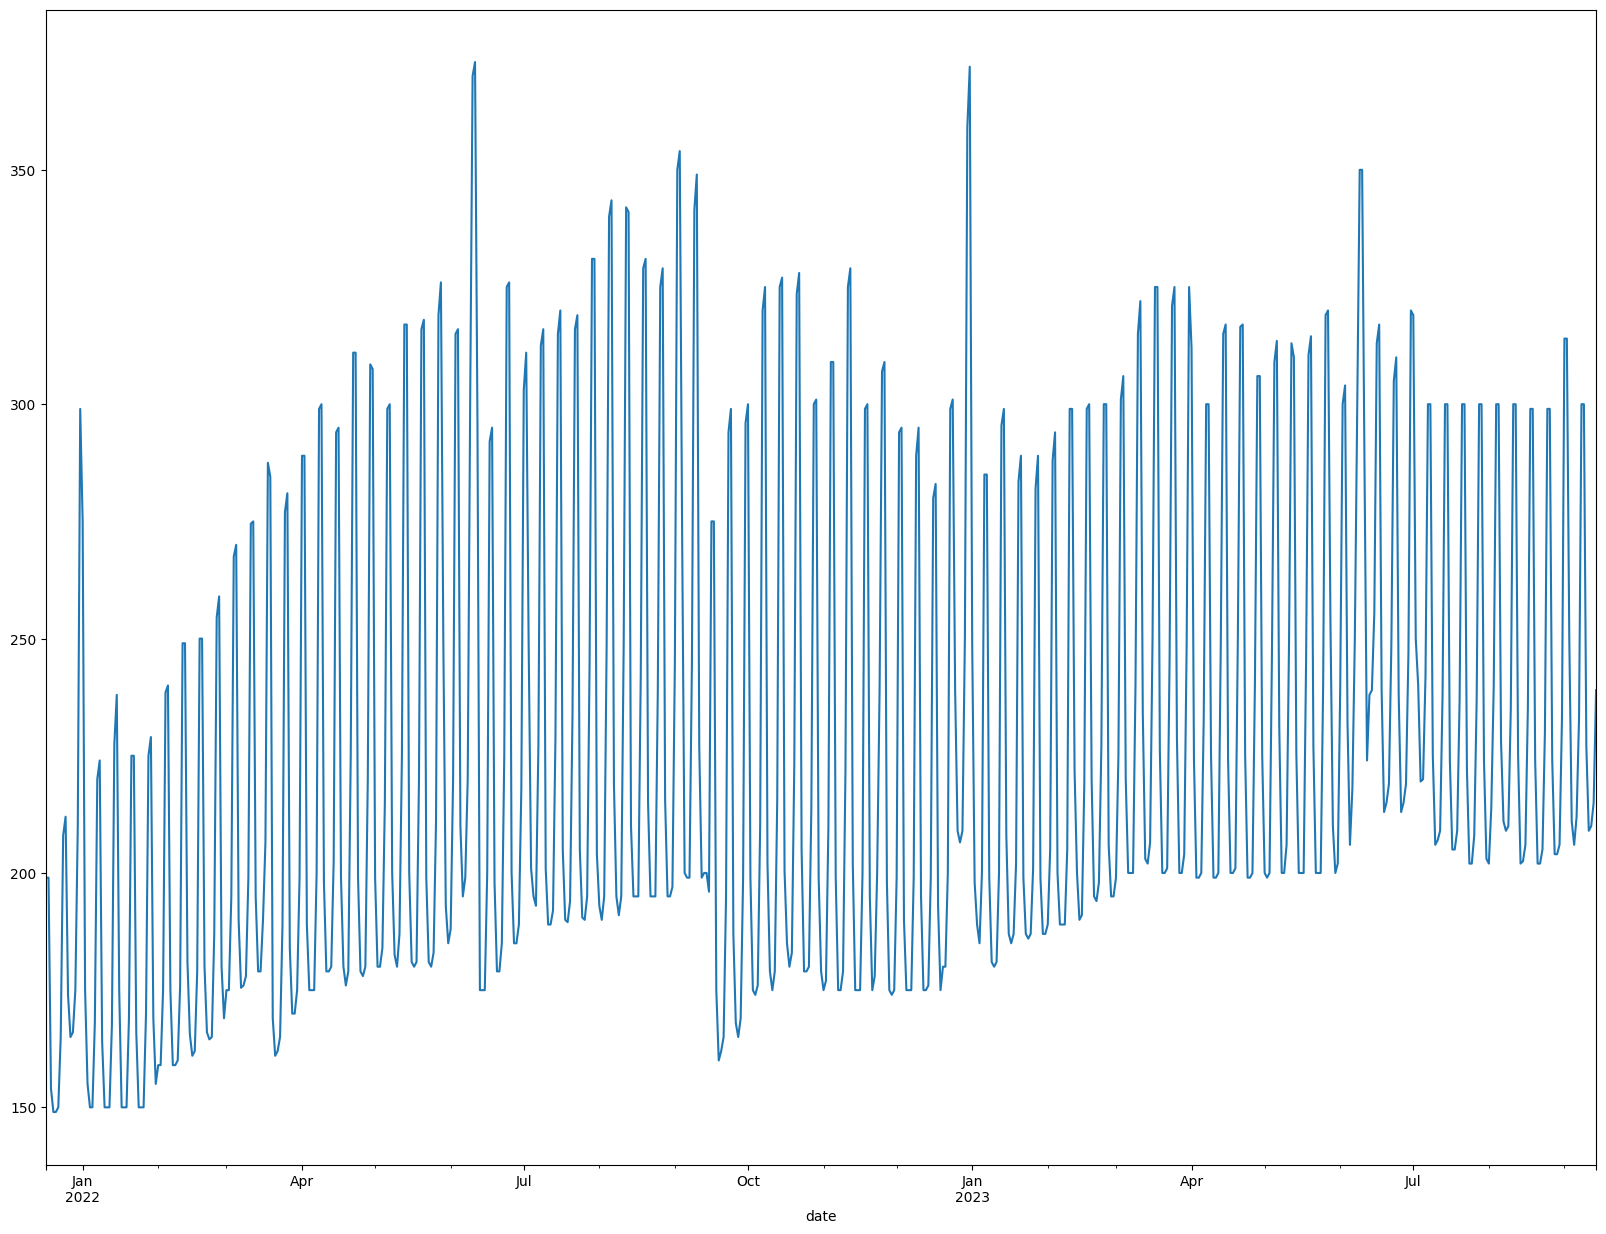

In [24]:
df_calendar.groupby('date')['price_dollars'].agg(np.median).plot.line('date', 'price_dollars', figsize=(20, 15))

## Market Demand

**Occupancy Rate**

done in analysis.twb 

## Reading Reviews

In [25]:
# Merge 4 quarters reviews data
df_reviews = pd.concat([pd.read_csv('data/2021-12-17/reviews1.csv',parse_dates=['date']),
                pd.read_csv('data/2022-03-20/reviews2.csv',parse_dates=['date']),
                pd.read_csv('data/2022-06-13/reviews3.csv',parse_dates=['date']),
                pd.read_csv('data/2022-09-15/reviews4.csv',parse_dates=['date'])], axis = 0 , ignore_index=True)
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6422,1927,2009-04-30,14100,Melissa,I can't say enough about how wonderful it was ...
1,6422,3867,2009-06-11,17413,Raquel,Michelle and Collier's home is wonderful! They...
2,6422,4159,2009-06-17,20253,Ulrike,I spent one night at Michele's home and felt j...
3,6422,5724,2009-07-18,22544,Phil,Michele and Collier are two of the loveliest p...
4,6422,11891,2009-09-29,33409,Claire,We had the most lovely time staying with Miche...


In [26]:
print(f'After loading shape of the dataframe: {df_reviews.shape}')

After loading shape of the dataframe: (1756645, 6)


In [27]:
# Retrieve the latest review of the listing given by each individual
df_reviews.drop_duplicates(subset=['listing_id','id','date','reviewer_id'],\
    inplace=True,ignore_index=True,keep='last')

In [28]:
print(f'After removing duplicates shape of the dataframe: {df_reviews.shape}')

After removing duplicates shape of the dataframe: (549142, 6)


**Pre-processing of the text --> to make it clean**

In [29]:
# Check for the null values in the reviews dataframe
# df_reviews[df_reviews.isna().any(axis=1)]
df_reviews.isnull().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      1
comments         201
dtype: int64

In [30]:
df_reviews[df_reviews['reviewer_name'].isnull()]

,listing_id,id,date,reviewer_id,reviewer_name,comments
65579,3710914,115989408,2016-11-27,24562860,NaN,this house is amazing. My family really love t...


In [31]:
# Let us see other records with the same reviewer_id
df_reviews[df_reviews['reviewer_id'] == 24562860]

,listing_id,id,date,reviewer_id,reviewer_name,comments
65579,3710914,115989408,2016-11-27,24562860,NaN,this house is amazing. My family really love t...


In [32]:
df_reviews[df_reviews['comments'].isnull()]

,listing_id,id,date,reviewer_id,reviewer_name,comments
936,6276671,741973821,2021-03-24,344950784,Gregory,NaN
1021,8208036,173588705,2017-07-23,110869532,Damian,NaN
1845,10747246,262378718,2018-05-08,17239158,Andrew,NaN
3943,13884573,768146925,2021-06-08,22306297,Joe,NaN
4539,15706425,731712909,2021-02-15,57774661,George,NaN
...,...,...,...,...,...,...
531353,559383276976021385,703642146679840059,2022-08-28,349777746,Athanasios,NaN
533615,590653850968352802,689124790736796620,2022-08-08,423756434,Melissa,NaN
535343,606740002544154300,683290083229480594,2022-07-31,407130766,Addison,NaN
535778,598489759351216400,683343309732917421,2022-07-31,421250044,Shelby,NaN


In [33]:
df_reviews_1 = pd.read_csv('data/2021-12-17/reviews1.csv', parse_dates=['date'])
df_reviews_2 = pd.read_csv('data/2022-03-20/reviews2.csv' , parse_dates=['date'])
df_reviews_3 = pd.read_csv('data/2022-06-13/reviews3.csv', parse_dates=['date'])
df_reviews_4 = pd.read_csv('data/2022-09-15/reviews4.csv', parse_dates=['date'])

In [34]:
print(df_reviews_1[df_reviews_1['reviewer_id'] == 344950784])
print(df_reviews_2[df_reviews_2['reviewer_id'] == 344950784])
print(df_reviews_3[df_reviews_3['reviewer_id'] == 344950784])
print(df_reviews_4[df_reviews_4['reviewer_id'] == 344950784])


       listing_id         id       date  reviewer_id reviewer_name comments
49809     6276671  741973821 2021-03-24    344950784       Gregory      NaN
Empty DataFrame
Columns: [listing_id, id, date, reviewer_id, reviewer_name, comments]
Index: []
Empty DataFrame
Columns: [listing_id, id, date, reviewer_id, reviewer_name, comments]
Index: []
Empty DataFrame
Columns: [listing_id, id, date, reviewer_id, reviewer_name, comments]
Index: []


In [35]:
df_reviews_1[(df_reviews_1['reviewer_id'] == 110869532) & (df_reviews_1['listing_id'] ==8208036)]
# print(df_reviews_2[df_reviews_2['reviewer_id'] == 110869532 & (df_reviews_2['listing_id'] ==8208036)])
# print(df_reviews_3[df_reviews_3['reviewer_id'] == 110869532 & (df_reviews_3['listing_id'] ==8208036)])
# print(df_reviews_4[df_reviews_4['reviewer_id'] == 110869532 & (df_reviews_4['listing_id'] ==8208036)])


,listing_id,id,date,reviewer_id,reviewer_name,comments
69490,8208036,173588705,2017-07-23,110869532,Damian,NaN
69509,8208036,235428746,2018-02-16,110869532,Damian,"Great location next to Vanderbilt, Belmont, an..."


In [36]:
# I will remove those rows from the dataframe that has null comments
df_reviews.dropna(subset = ['comments'], inplace = True)
print(f'The dataframe shape after dropping comments null values : {df_reviews.shape}')

The dataframe shape after dropping comments null values : (548941, 6)


In [37]:
df_reviews['comments'].head(30).to_csv("comments.csv",index=False)

In [47]:
# Cleaning of the text
# Function for the removal of punctuation
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

#storing the puntuation free text
df_reviews['clean_comment']= df_reviews['comments'].apply(lambda x:remove_punctuation(x))
# data.head()
df_reviews['clean_comment'].head(30).to_csv("comments.csv",index=False)

In [48]:
# Lowering the text
df_reviews['clean_comment'] = df_reviews['clean_comment'].str.lower()
df_reviews['clean_comment'].head(30).to_csv("comments.csv",index=False)

In [41]:
# Expanding the contractions+
cont = Contractions('GoogleNews-vectors-negative300.bin')
cont.load_models()

In [49]:
def fix_contractions(text):
    expanded = cont.expand_texts([text], precise=True)
    return list(expanded)[0]

#storing the puntuation free text
df_reviews['clean_comment'] = df_reviews['clean_comment'].apply(lambda x:fix_contractions(x))
# data.head()
df_reviews['clean_comment'].head(30).to_csv("comments.csv",index=False)

['great place and location near to downtown kurt was very nice and helped us in getting to know nashville']
['we really enjoyed our stay here  the location was great and the price was amazing  alyce was quick to respond to all of my questions and was very accommodating whenever we needed something   the space is private  when i was in one bedroom with the door shut i never heard my friends in the other room or even the shower running  if you are allergic to cats its not the right place for you  i found myself sneezing and remembered this about myself even  it did not stop me from cuddling up with her kitty when he wanted to visit though  ']
['alyces place is very nice its quite spacious and is very well taken care of its decorated very well and features lovely features like lots of easily accessible power outlets and desks the beds are big and comfy and its a short trip to downtown nashville you can tell she puts great care into her home and yard ']
['alyce is such a lovely and friendl

KeyboardInterrupt: 